# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

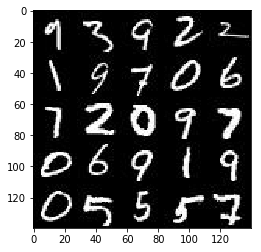

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

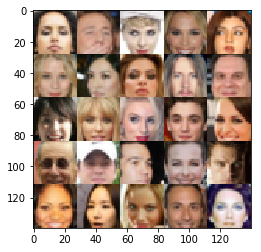

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
                             
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    training = is_train
    with tf.variable_scope('generator', reuse=(not training)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if data_image_mode == 'RGB':
        dim = 3
    else:
        dim = 1
    
    input_real, input_z, var_learning_rate = model_inputs(data_shape[1], data_shape[2], dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, var_learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 50
    show_every = 300
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                                
                images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    input_real: images,
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                   })
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                })
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.3f}...".format(train_loss_d),
                          "Generator Loss: {:.3f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.503... Generator Loss: 0.367
Epoch 1/2... Discriminator Loss: 0.862... Generator Loss: 0.921
Epoch 1/2... Discriminator Loss: 0.881... Generator Loss: 1.224
Epoch 1/2... Discriminator Loss: 0.788... Generator Loss: 1.176
Epoch 1/2... Discriminator Loss: 0.878... Generator Loss: 1.145
Epoch 1/2... Discriminator Loss: 0.694... Generator Loss: 1.035


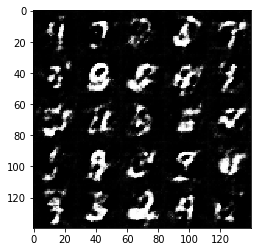

Epoch 1/2... Discriminator Loss: 0.824... Generator Loss: 1.192
Epoch 1/2... Discriminator Loss: 0.608... Generator Loss: 1.220
Epoch 1/2... Discriminator Loss: 0.698... Generator Loss: 0.959
Epoch 1/2... Discriminator Loss: 0.313... Generator Loss: 2.162
Epoch 1/2... Discriminator Loss: 0.363... Generator Loss: 1.675
Epoch 1/2... Discriminator Loss: 0.588... Generator Loss: 1.159


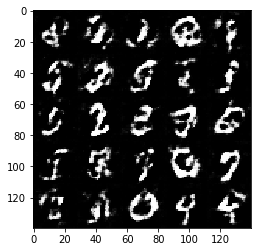

Epoch 1/2... Discriminator Loss: 0.539... Generator Loss: 2.173
Epoch 1/2... Discriminator Loss: 0.451... Generator Loss: 1.711
Epoch 1/2... Discriminator Loss: 0.516... Generator Loss: 1.359
Epoch 1/2... Discriminator Loss: 0.615... Generator Loss: 1.643
Epoch 1/2... Discriminator Loss: 0.687... Generator Loss: 2.280
Epoch 1/2... Discriminator Loss: 1.035... Generator Loss: 0.805


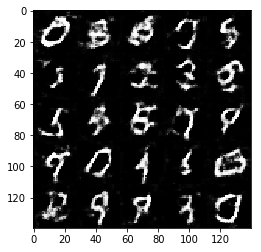

Epoch 1/2... Discriminator Loss: 0.820... Generator Loss: 1.229
Epoch 1/2... Discriminator Loss: 0.729... Generator Loss: 0.945
Epoch 1/2... Discriminator Loss: 0.616... Generator Loss: 1.351
Epoch 1/2... Discriminator Loss: 1.314... Generator Loss: 0.424
Epoch 1/2... Discriminator Loss: 1.043... Generator Loss: 0.671
Epoch 1/2... Discriminator Loss: 1.026... Generator Loss: 1.376


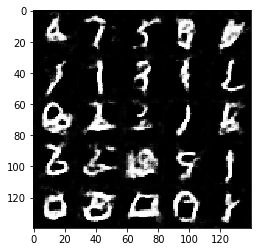

Epoch 1/2... Discriminator Loss: 0.879... Generator Loss: 1.634
Epoch 1/2... Discriminator Loss: 0.683... Generator Loss: 1.245
Epoch 1/2... Discriminator Loss: 0.860... Generator Loss: 1.421
Epoch 1/2... Discriminator Loss: 0.872... Generator Loss: 1.036
Epoch 1/2... Discriminator Loss: 0.718... Generator Loss: 1.311
Epoch 1/2... Discriminator Loss: 0.434... Generator Loss: 1.487


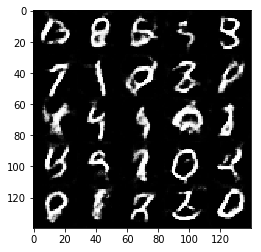

Epoch 1/2... Discriminator Loss: 0.604... Generator Loss: 1.273
Epoch 1/2... Discriminator Loss: 0.850... Generator Loss: 0.846
Epoch 1/2... Discriminator Loss: 0.776... Generator Loss: 1.239
Epoch 1/2... Discriminator Loss: 0.597... Generator Loss: 2.046
Epoch 1/2... Discriminator Loss: 0.956... Generator Loss: 0.753
Epoch 1/2... Discriminator Loss: 0.881... Generator Loss: 0.980


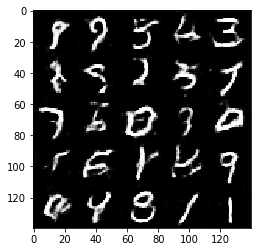

Epoch 1/2... Discriminator Loss: 0.581... Generator Loss: 1.281
Epoch 1/2... Discriminator Loss: 0.607... Generator Loss: 1.355
Epoch 1/2... Discriminator Loss: 0.612... Generator Loss: 1.229
Epoch 1/2... Discriminator Loss: 0.588... Generator Loss: 1.198
Epoch 1/2... Discriminator Loss: 1.033... Generator Loss: 0.763
Epoch 1/2... Discriminator Loss: 0.451... Generator Loss: 1.489


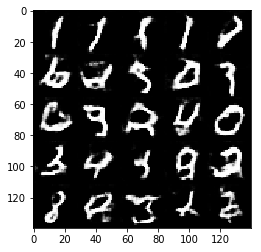

Epoch 1/2... Discriminator Loss: 0.637... Generator Loss: 1.194
Epoch 1/2... Discriminator Loss: 0.763... Generator Loss: 0.972
Epoch 1/2... Discriminator Loss: 0.520... Generator Loss: 1.158
Epoch 1/2... Discriminator Loss: 1.147... Generator Loss: 0.497
Epoch 1/2... Discriminator Loss: 0.370... Generator Loss: 2.033
Epoch 1/2... Discriminator Loss: 0.427... Generator Loss: 1.519


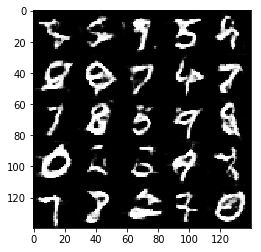

Epoch 1/2... Discriminator Loss: 0.788... Generator Loss: 1.083
Epoch 1/2... Discriminator Loss: 0.300... Generator Loss: 2.213
Epoch 1/2... Discriminator Loss: 0.368... Generator Loss: 1.972
Epoch 1/2... Discriminator Loss: 0.584... Generator Loss: 1.278
Epoch 1/2... Discriminator Loss: 0.688... Generator Loss: 1.246
Epoch 1/2... Discriminator Loss: 0.924... Generator Loss: 0.852


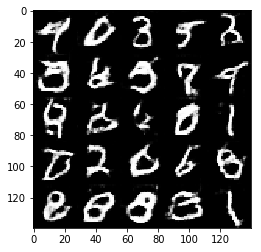

Epoch 1/2... Discriminator Loss: 0.953... Generator Loss: 0.697
Epoch 1/2... Discriminator Loss: 1.130... Generator Loss: 0.517
Epoch 1/2... Discriminator Loss: 0.654... Generator Loss: 1.027
Epoch 1/2... Discriminator Loss: 0.548... Generator Loss: 1.086
Epoch 1/2... Discriminator Loss: 0.345... Generator Loss: 1.759
Epoch 1/2... Discriminator Loss: 0.874... Generator Loss: 0.754


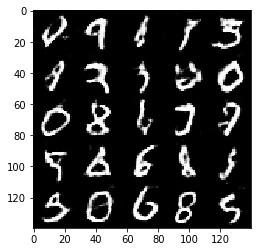

Epoch 2/2... Discriminator Loss: 0.795... Generator Loss: 0.871
Epoch 2/2... Discriminator Loss: 0.450... Generator Loss: 1.331
Epoch 2/2... Discriminator Loss: 1.204... Generator Loss: 0.490
Epoch 2/2... Discriminator Loss: 0.652... Generator Loss: 1.198
Epoch 2/2... Discriminator Loss: 0.480... Generator Loss: 1.569
Epoch 2/2... Discriminator Loss: 0.448... Generator Loss: 1.502


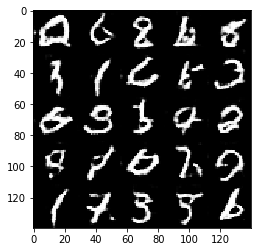

Epoch 2/2... Discriminator Loss: 0.604... Generator Loss: 1.396
Epoch 2/2... Discriminator Loss: 0.724... Generator Loss: 1.067
Epoch 2/2... Discriminator Loss: 0.363... Generator Loss: 1.488
Epoch 2/2... Discriminator Loss: 0.293... Generator Loss: 1.771
Epoch 2/2... Discriminator Loss: 0.743... Generator Loss: 2.517
Epoch 2/2... Discriminator Loss: 1.260... Generator Loss: 0.419


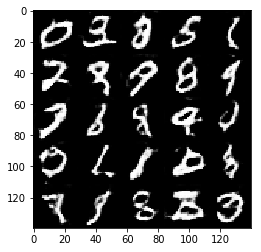

Epoch 2/2... Discriminator Loss: 0.654... Generator Loss: 0.994
Epoch 2/2... Discriminator Loss: 1.081... Generator Loss: 0.530
Epoch 2/2... Discriminator Loss: 0.410... Generator Loss: 1.448
Epoch 2/2... Discriminator Loss: 0.527... Generator Loss: 1.272
Epoch 2/2... Discriminator Loss: 0.442... Generator Loss: 2.605
Epoch 2/2... Discriminator Loss: 0.325... Generator Loss: 1.750


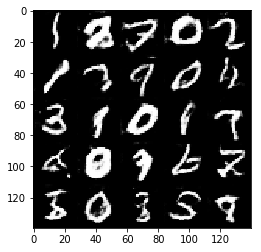

Epoch 2/2... Discriminator Loss: 0.502... Generator Loss: 1.814
Epoch 2/2... Discriminator Loss: 0.437... Generator Loss: 1.612
Epoch 2/2... Discriminator Loss: 0.506... Generator Loss: 1.278
Epoch 2/2... Discriminator Loss: 0.929... Generator Loss: 0.813
Epoch 2/2... Discriminator Loss: 0.493... Generator Loss: 1.423
Epoch 2/2... Discriminator Loss: 0.573... Generator Loss: 1.440


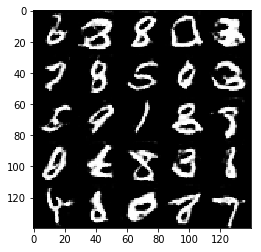

Epoch 2/2... Discriminator Loss: 0.529... Generator Loss: 1.264
Epoch 2/2... Discriminator Loss: 0.683... Generator Loss: 1.071
Epoch 2/2... Discriminator Loss: 0.374... Generator Loss: 1.888
Epoch 2/2... Discriminator Loss: 0.223... Generator Loss: 2.514
Epoch 2/2... Discriminator Loss: 0.781... Generator Loss: 0.781
Epoch 2/2... Discriminator Loss: 0.455... Generator Loss: 1.373


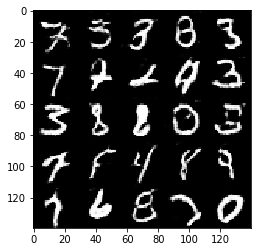

Epoch 2/2... Discriminator Loss: 0.423... Generator Loss: 1.591
Epoch 2/2... Discriminator Loss: 0.238... Generator Loss: 2.393
Epoch 2/2... Discriminator Loss: 0.660... Generator Loss: 1.302
Epoch 2/2... Discriminator Loss: 0.265... Generator Loss: 2.202
Epoch 2/2... Discriminator Loss: 0.481... Generator Loss: 1.446
Epoch 2/2... Discriminator Loss: 0.433... Generator Loss: 1.495


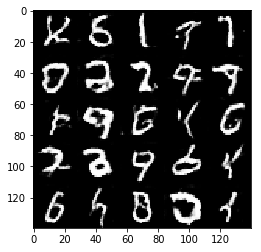

Epoch 2/2... Discriminator Loss: 0.391... Generator Loss: 1.532
Epoch 2/2... Discriminator Loss: 0.388... Generator Loss: 1.792
Epoch 2/2... Discriminator Loss: 0.396... Generator Loss: 1.731
Epoch 2/2... Discriminator Loss: 0.638... Generator Loss: 1.014
Epoch 2/2... Discriminator Loss: 0.387... Generator Loss: 1.827
Epoch 2/2... Discriminator Loss: 0.190... Generator Loss: 3.496


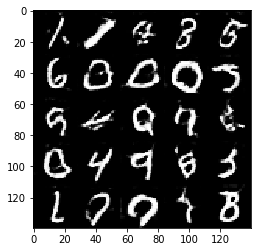

Epoch 2/2... Discriminator Loss: 0.420... Generator Loss: 1.494
Epoch 2/2... Discriminator Loss: 0.267... Generator Loss: 2.004
Epoch 2/2... Discriminator Loss: 0.450... Generator Loss: 1.575
Epoch 2/2... Discriminator Loss: 0.761... Generator Loss: 0.889
Epoch 2/2... Discriminator Loss: 0.564... Generator Loss: 2.777
Epoch 2/2... Discriminator Loss: 0.396... Generator Loss: 1.697


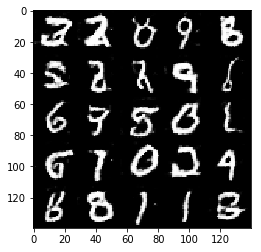

Epoch 2/2... Discriminator Loss: 0.668... Generator Loss: 0.887
Epoch 2/2... Discriminator Loss: 0.323... Generator Loss: 2.363
Epoch 2/2... Discriminator Loss: 0.191... Generator Loss: 4.164
Epoch 2/2... Discriminator Loss: 0.557... Generator Loss: 1.159
Epoch 2/2... Discriminator Loss: 0.612... Generator Loss: 1.138
Epoch 2/2... Discriminator Loss: 0.440... Generator Loss: 1.666


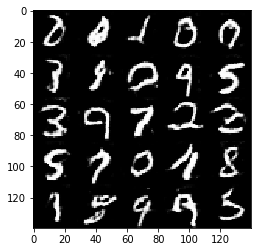

Epoch 2/2... Discriminator Loss: 0.811... Generator Loss: 0.803
Epoch 2/2... Discriminator Loss: 0.539... Generator Loss: 1.209
Epoch 2/2... Discriminator Loss: 0.368... Generator Loss: 1.681
Epoch 2/2... Discriminator Loss: 0.401... Generator Loss: 1.734
Epoch 2/2... Discriminator Loss: 0.284... Generator Loss: 2.528
Epoch 2/2... Discriminator Loss: 0.433... Generator Loss: 1.304


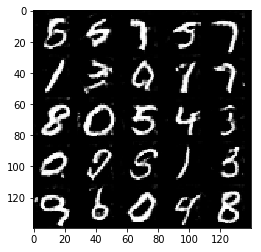

In [12]:
batch_size = 20
z_dim = 100
learning_rate = 0.0001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.047... Generator Loss: 4.135
Epoch 1/1... Discriminator Loss: 0.025... Generator Loss: 4.353
Epoch 1/1... Discriminator Loss: 0.012... Generator Loss: 4.921
Epoch 1/1... Discriminator Loss: 0.005... Generator Loss: 6.509
Epoch 1/1... Discriminator Loss: 0.365... Generator Loss: 2.036
Epoch 1/1... Discriminator Loss: 0.427... Generator Loss: 1.525


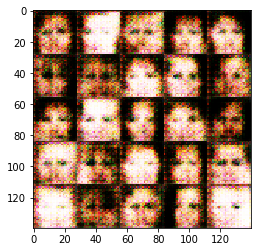

Epoch 1/1... Discriminator Loss: 0.384... Generator Loss: 2.102
Epoch 1/1... Discriminator Loss: 0.811... Generator Loss: 1.957
Epoch 1/1... Discriminator Loss: 0.991... Generator Loss: 0.666
Epoch 1/1... Discriminator Loss: 1.049... Generator Loss: 0.733
Epoch 1/1... Discriminator Loss: 0.348... Generator Loss: 1.872
Epoch 1/1... Discriminator Loss: 0.341... Generator Loss: 2.917


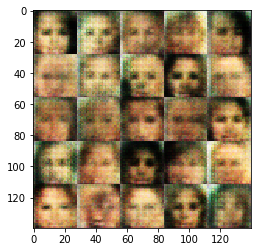

Epoch 1/1... Discriminator Loss: 0.696... Generator Loss: 1.036
Epoch 1/1... Discriminator Loss: 0.512... Generator Loss: 1.480
Epoch 1/1... Discriminator Loss: 0.974... Generator Loss: 0.993
Epoch 1/1... Discriminator Loss: 0.789... Generator Loss: 1.222
Epoch 1/1... Discriminator Loss: 0.876... Generator Loss: 1.530
Epoch 1/1... Discriminator Loss: 0.931... Generator Loss: 1.553


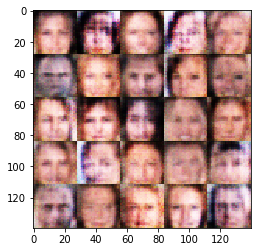

Epoch 1/1... Discriminator Loss: 0.978... Generator Loss: 1.013
Epoch 1/1... Discriminator Loss: 1.029... Generator Loss: 1.390
Epoch 1/1... Discriminator Loss: 1.299... Generator Loss: 1.252
Epoch 1/1... Discriminator Loss: 1.015... Generator Loss: 0.762
Epoch 1/1... Discriminator Loss: 0.778... Generator Loss: 1.481
Epoch 1/1... Discriminator Loss: 0.820... Generator Loss: 1.023


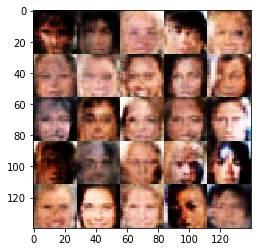

Epoch 1/1... Discriminator Loss: 0.745... Generator Loss: 1.465
Epoch 1/1... Discriminator Loss: 1.040... Generator Loss: 0.855
Epoch 1/1... Discriminator Loss: 1.097... Generator Loss: 0.597
Epoch 1/1... Discriminator Loss: 0.824... Generator Loss: 1.078
Epoch 1/1... Discriminator Loss: 0.785... Generator Loss: 1.493
Epoch 1/1... Discriminator Loss: 0.826... Generator Loss: 1.055


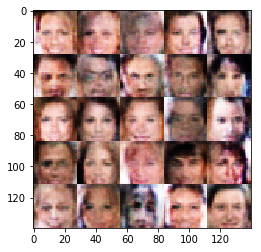

Epoch 1/1... Discriminator Loss: 0.937... Generator Loss: 1.160
Epoch 1/1... Discriminator Loss: 0.729... Generator Loss: 1.381
Epoch 1/1... Discriminator Loss: 0.885... Generator Loss: 0.940
Epoch 1/1... Discriminator Loss: 0.769... Generator Loss: 1.440
Epoch 1/1... Discriminator Loss: 0.921... Generator Loss: 0.829
Epoch 1/1... Discriminator Loss: 0.977... Generator Loss: 0.801


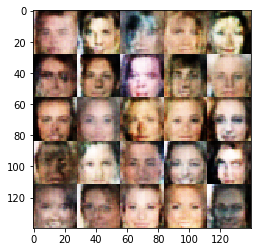

Epoch 1/1... Discriminator Loss: 0.715... Generator Loss: 1.301
Epoch 1/1... Discriminator Loss: 0.718... Generator Loss: 1.053
Epoch 1/1... Discriminator Loss: 0.834... Generator Loss: 1.184
Epoch 1/1... Discriminator Loss: 0.798... Generator Loss: 0.919
Epoch 1/1... Discriminator Loss: 0.764... Generator Loss: 1.025
Epoch 1/1... Discriminator Loss: 0.774... Generator Loss: 1.617


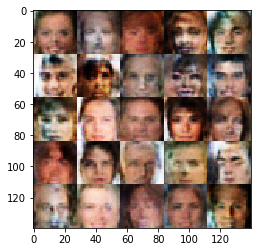

Epoch 1/1... Discriminator Loss: 0.639... Generator Loss: 1.085
Epoch 1/1... Discriminator Loss: 1.008... Generator Loss: 0.650
Epoch 1/1... Discriminator Loss: 0.840... Generator Loss: 0.912
Epoch 1/1... Discriminator Loss: 0.496... Generator Loss: 1.551
Epoch 1/1... Discriminator Loss: 0.528... Generator Loss: 1.449
Epoch 1/1... Discriminator Loss: 0.333... Generator Loss: 1.945


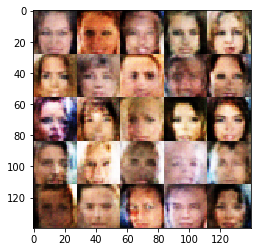

Epoch 1/1... Discriminator Loss: 0.406... Generator Loss: 1.727
Epoch 1/1... Discriminator Loss: 1.350... Generator Loss: 0.474
Epoch 1/1... Discriminator Loss: 0.220... Generator Loss: 3.475
Epoch 1/1... Discriminator Loss: 0.161... Generator Loss: 3.302
Epoch 1/1... Discriminator Loss: 1.600... Generator Loss: 0.287
Epoch 1/1... Discriminator Loss: 0.408... Generator Loss: 2.987


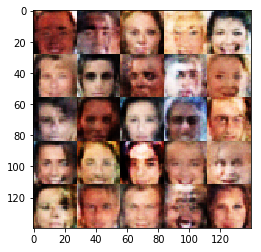

Epoch 1/1... Discriminator Loss: 0.584... Generator Loss: 1.362
Epoch 1/1... Discriminator Loss: 0.653... Generator Loss: 3.943
Epoch 1/1... Discriminator Loss: 0.154... Generator Loss: 4.698
Epoch 1/1... Discriminator Loss: 0.425... Generator Loss: 1.435
Epoch 1/1... Discriminator Loss: 0.189... Generator Loss: 4.059
Epoch 1/1... Discriminator Loss: 0.559... Generator Loss: 1.621


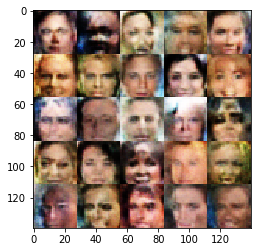

Epoch 1/1... Discriminator Loss: 0.324... Generator Loss: 2.486
Epoch 1/1... Discriminator Loss: 0.188... Generator Loss: 4.105
Epoch 1/1... Discriminator Loss: 0.140... Generator Loss: 3.942
Epoch 1/1... Discriminator Loss: 0.349... Generator Loss: 5.809
Epoch 1/1... Discriminator Loss: 0.595... Generator Loss: 2.387
Epoch 1/1... Discriminator Loss: 0.100... Generator Loss: 3.708


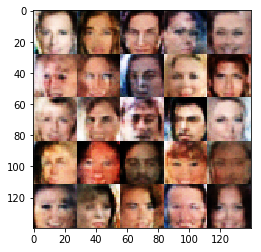

Epoch 1/1... Discriminator Loss: 0.171... Generator Loss: 4.033
Epoch 1/1... Discriminator Loss: 0.529... Generator Loss: 1.265
Epoch 1/1... Discriminator Loss: 0.290... Generator Loss: 2.032
Epoch 1/1... Discriminator Loss: 0.073... Generator Loss: 4.235
Epoch 1/1... Discriminator Loss: 0.150... Generator Loss: 3.132
Epoch 1/1... Discriminator Loss: 0.851... Generator Loss: 0.716


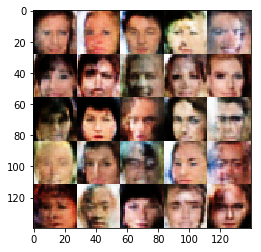

Epoch 1/1... Discriminator Loss: 0.122... Generator Loss: 4.306
Epoch 1/1... Discriminator Loss: 0.204... Generator Loss: 2.272
Epoch 1/1... Discriminator Loss: 0.193... Generator Loss: 2.767
Epoch 1/1... Discriminator Loss: 0.195... Generator Loss: 2.405
Epoch 1/1... Discriminator Loss: 0.217... Generator Loss: 2.191
Epoch 1/1... Discriminator Loss: 0.136... Generator Loss: 3.494


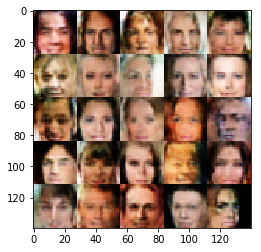

Epoch 1/1... Discriminator Loss: 0.135... Generator Loss: 3.825
Epoch 1/1... Discriminator Loss: 0.075... Generator Loss: 4.988
Epoch 1/1... Discriminator Loss: 0.065... Generator Loss: 4.032


In [13]:
batch_size = 50
z_dim = 100
learning_rate = 0.0001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.